
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WUR-AI/AgML-CY-Bench/blob/main/notebooks/cybench_summary.ipynb)

# CY-Bench dataset summary

Based on a notebook contributed by Ioannis N. Athanasiadis.

## Install packages

Not needed if the packages are installed in the python environment

In [ ]:
%pip install --quiet plottable pycountry

## Load dataset summary

This dataset summary is produced by running the `cybench/runs/benchmark_summary.py`. Upload the resulting `dataset_summary.csv` manually.

In [2]:
import os
import pandas as pd
import pycountry

summary_df = pd.read_csv("/content/dataset_summary.csv")
summary_df["country_code"] = summary_df["Dataset"].str[-2:]
summary_df["Labels Count Per Year"] = summary_df["Labels Count Per Year"].apply(lambda x: [int(p) for p in x.split(" ")])

countries = summary_df["country_code"].unique()

summary_per_country = {}
for cn in countries:
  for crop in ["maize", "wheat"]:
    cn_crop_df = summary_df[summary_df["Dataset"] == crop + "_" + cn]
    years, adm_id_count, labels_count, labels_count_per_year = None, None, None, None
    if (not cn_crop_df.empty):
      years = cn_crop_df["Min Year-Max Year"].values[0]
      adm_id_count = cn_crop_df["Admin Regions Count"].values[0]
      labels_count = cn_crop_df["Labels Count"].values[0]
      labels_count_per_year = cn_crop_df["Labels Count Per Year"].values[0]

    cn_summary = []
    if (cn in summary_per_country):
      cn_summary = summary_per_country[cn]

    cn_summary += [years, adm_id_count, labels_count, labels_count_per_year]
    if (cn == "EL"):
      summary_per_country["GR"] = cn_summary
    else:
      summary_per_country[cn] = cn_summary

summary_cols = ["maize_years", "maize_adm_id_count",
                "maize_labels_count", "maize_labels_count_per_year",
                "wheat_years", "wheat_adm_id_count",
                "wheat_labels_count", "wheat_labels_count_per_year"]
summary_df = pd.DataFrame.from_dict(summary_per_country, columns=summary_cols, orient="index")

ASIA_COUNTRIES = ["CN", "IN"]
FEWSNET_COUNTRIES = ["AO", "BF", "ET", "LS", "MG", "MW", "MZ", "NE", "SN", "TD", "ZA", "ZM"]
EU_COUNTRIES = ["AT", "BE", "BG", "CZ", "DE", "DK", "GR", "ES", "FR", "HR", "HU",
                "IT", "LT", "NL", "PL", "PT",  "RO", "SE", "SK"]
NORTH_AMERICA_COUNTRIES = ["MX", "US"]
SOUTH_AMERICA_COUNTRIES = ["AR", "BR"]

custom_order = ["AU"] + ASIA_COUNTRIES + FEWSNET_COUNTRIES + EU_COUNTRIES
custom_order += NORTH_AMERICA_COUNTRIES + SOUTH_AMERICA_COUNTRIES

summary_df = summary_df.reindex(index=custom_order)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={"index": "country_code"}, inplace=True)
summary_df["Country"] = summary_df["country_code"].apply(lambda x: pycountry.countries.get(alpha_2=x).name)
summary_df.set_index("Country", inplace=True)

for c in summary_cols:
  if (c.endswith("years")):
    summary_df[c] = summary_df[c].fillna("-")

  if (c.endswith("count")):
    summary_df[c] = summary_df[c].fillna(0)
    summary_df[c] = summary_df[c].astype("int")

In [ ]:
summary_df

## Get median admin unit size in hectares

First upload `polygons.zip` manually

In [ ]:
# unzip the manually uploaded polygons.zip
!unzip /content/polygons -d /content/

In [11]:
from pyproj import CRS
import geopandas as gpd
import os


def get_utm_crs(lat, lon):
    # Calculate UTM zone number
    utm_zone = int((lon + 180) // 6) + 1

    # Determine the hemisphere and construct the EPSG code
    is_northern = lat >= 0
    epsg_code = 32600 + utm_zone if is_northern else 32700 + utm_zone

    return int(epsg_code)


def get_area(path, region="US"):

    """
    Args
        path: folder containing shapefile of polygons
        region: two-character iso code (representing a country)

    Returns
        median area of administrative divisions in sq.km for each country

    """

    sel_shapes = gpd.read_file(os.path.join(os.path.join(path, region), region+'.shp'))

    # handle unrecognisable CRS for Brazil (BR)
    if (region != "BR"):
        sel_shapes = sel_shapes.to_crs(4326)
    else:
        sel_shapes = sel_shapes.set_crs("EPSG:4326")

    # get centroid
    sel_shapes['centroid'] = sel_shapes.geometry.centroid

    # get lat, lon per centroid to generate utm zone
    sel_shapes['utm_crs'] = sel_shapes.apply(lambda row: get_utm_crs(row['centroid'].y, row['centroid'].x), axis=1)


    # get most occuring utm
    utm_frequent = sel_shapes['utm_crs'].mode().iloc[0]
    # print(region, utm_frequent)

    # calculate size in utm
    sel_shapes_utm = sel_shapes.to_crs(epsg=utm_frequent)
    sel_shapes_utm['area_sqkm'] =  sel_shapes_utm.geometry.area / 1000000  # Convert m² to sq.km
    average_size_ha = sel_shapes_utm['area_sqkm'].median()

    return region, average_size_ha

In [ ]:
# get list of 2-character country code
iso = summary_df['country_code'].tolist()

# rename Greece iso from GR to EL
iso.remove('GR')
iso.append('EL')

# set path to shapefile
path = '/content/polygons'

# holder for utm zone -geometry
list_country = []
list_size = []

for i in iso:
    region, average_size_ha = get_area(path=path, region=i)
    list_country.append(region)
    list_size.append(average_size_ha)

adm_units_sizes = pd.DataFrame({
'country_code': list_country,
'area_sqkm': list_size,
})


# Undo Greece ISO to 'GR'
adm_units_sizes.loc[adm_units_sizes['country_code'] == 'EL', 'country_code'] = 'GR'

In [17]:
summary_df = summary_df.merge(adm_units_sizes, on='country_code', how='left')
summary_df["Country"] = summary_df["country_code"].apply(lambda x: pycountry.countries.get(alpha_2=x).name)
summary_df.set_index("Country", inplace=True)

## Plot summaries

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.axes
import typing

def densities_plot(ax: matplotlib.axes.Axes, val: typing.Any, hideAxes=True, startx=2003) -> typing.Optional[matplotlib.container.BarContainer]:
    """
    Plots a density bar chart on the given axes. Handles cases where `val` is None or empty.

    Parameters:
    - ax: The matplotlib axes on which to plot.
    - val: The data values to plot. If None or empty, no plot is created.
    - hideAxes: If True, hides the axes.
    - startx: The starting x-value for the bars.

    Returns:
    - The BarContainer if data is plotted, None if `val` is None or empty.
    """
    if val is None or len(val) == 0:
        # If `val` is None or empty, display a placeholder message
        ax.text(
            0.5, 0.5, "-",
            ha="center", va="center",
            transform=ax.transAxes
        )
        if hideAxes:
            ax.set_axis_off()
        return None

    # Proceed with plotting the bar chart
    bar = ax.bar(
        range(startx, startx + len(val)),
        val,
        color="lightblue"
    )
    if hideAxes:
        ax.set_axis_off()

    return bar

def handle_na(val: int) -> str:
    if (val == 0):
        return "-"
    else:
        return str(val)

# Test the above
ax = plt.axes()
bar = densities_plot(ax, summary_df["wheat_labels_count_per_year"]["Spain"])
plt.show()

In [37]:
import matplotlib.patches as patches
import math

def custom_cmap(s: pd.Series, cmap="GnBu"):
  vmin = s.min()
  vmax = s.max()
  norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
  m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

  return m.to_rgba


def calculate_circle_size(value, min_value=0, max_value=5000, min_radius=0.30, max_radius=0.50, steepness=10):
    """
    Calculate the circle size using a sigmoid-like scaling function.

    Parameters:
    - value: The input value.
    - min_value: The minimum value of the range.
    - max_value: The maximum value of the range.
    - min_radius: The minimum circle radius.
    - max_radius: The maximum circle radius.
    - steepness: Controls the steepness of the sigmoid curve (default is 10).

    Returns:
    - The scaled circle size.
    """
    # Normalize the value to a range between 0 and 1
    normalized_value = (value - min_value) / (max_value - min_value)
    normalized_value = max(0, min(normalized_value, 1))  # Ensure it's within [0, 1]

    # Apply a sigmoid-like transformation
    sigmoid_value = 1 / (1 + math.exp(-steepness * (normalized_value - 0.1)))

    # Scale to the desired circle size range
    circle_size = min_radius + sigmoid_value * (max_radius - min_radius)
    return circle_size


def custom_plot_fn(
    ax: matplotlib.axes.Axes,
    val: typing.Any,
    cmap: typing.Callable = None,
    min: int = 0,
    max: int = 5000
    ):

    if val == 0:
        ax.text(0.5, 0.5, f"{int(val)}", ha='center', va='center', fontsize=26)
        ax.axis('off')  # Ensure the axes are hidden
        return

    # Define the size of the circle based on the value
    circle_radius = calculate_circle_size(val, min_value=min, max_value=max)  # Ensure a minimum radius for small values

    maxval = int(0.75*max)
    if val > maxval:
      color = cmap(maxval)
    else:
      color = cmap(val)   # Get the rgba value for 'val'

    # Create a circle patch

    circle = patches.Circle((0.5, 0.5), radius=circle_radius, edgecolor='black', facecolor=color, lw=0)

    # Add the circle to the axes
    ax.add_patch(circle)

    # Add text in the center of the circle
    ax.text(0.5, 0.5, f"{int(val)}", ha='center', va='center', fontsize=26)

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')

    # Hide the axes
    ax.axis('off')


df_admin = pd.concat([summary_df["maize_adm_id_count"], summary_df["wheat_adm_id_count"]]).fillna(0)
df_labels = pd.concat([summary_df["maize_labels_count"], summary_df["wheat_labels_count"]]).fillna(0)
df_area = summary_df["area_sqkm"].fillna(0)

color_map_adm = custom_cmap(df_admin)
min_adm, max_adm = df_admin.min(), df_admin.max()
color_map_labels = custom_cmap(df_labels)
min_labels, max_labels = df_labels.min(), df_labels.max()
color_map_area = custom_cmap(df_area)
min_area, max_area = df_area.min(), df_area.max()

### Plot EU Countries

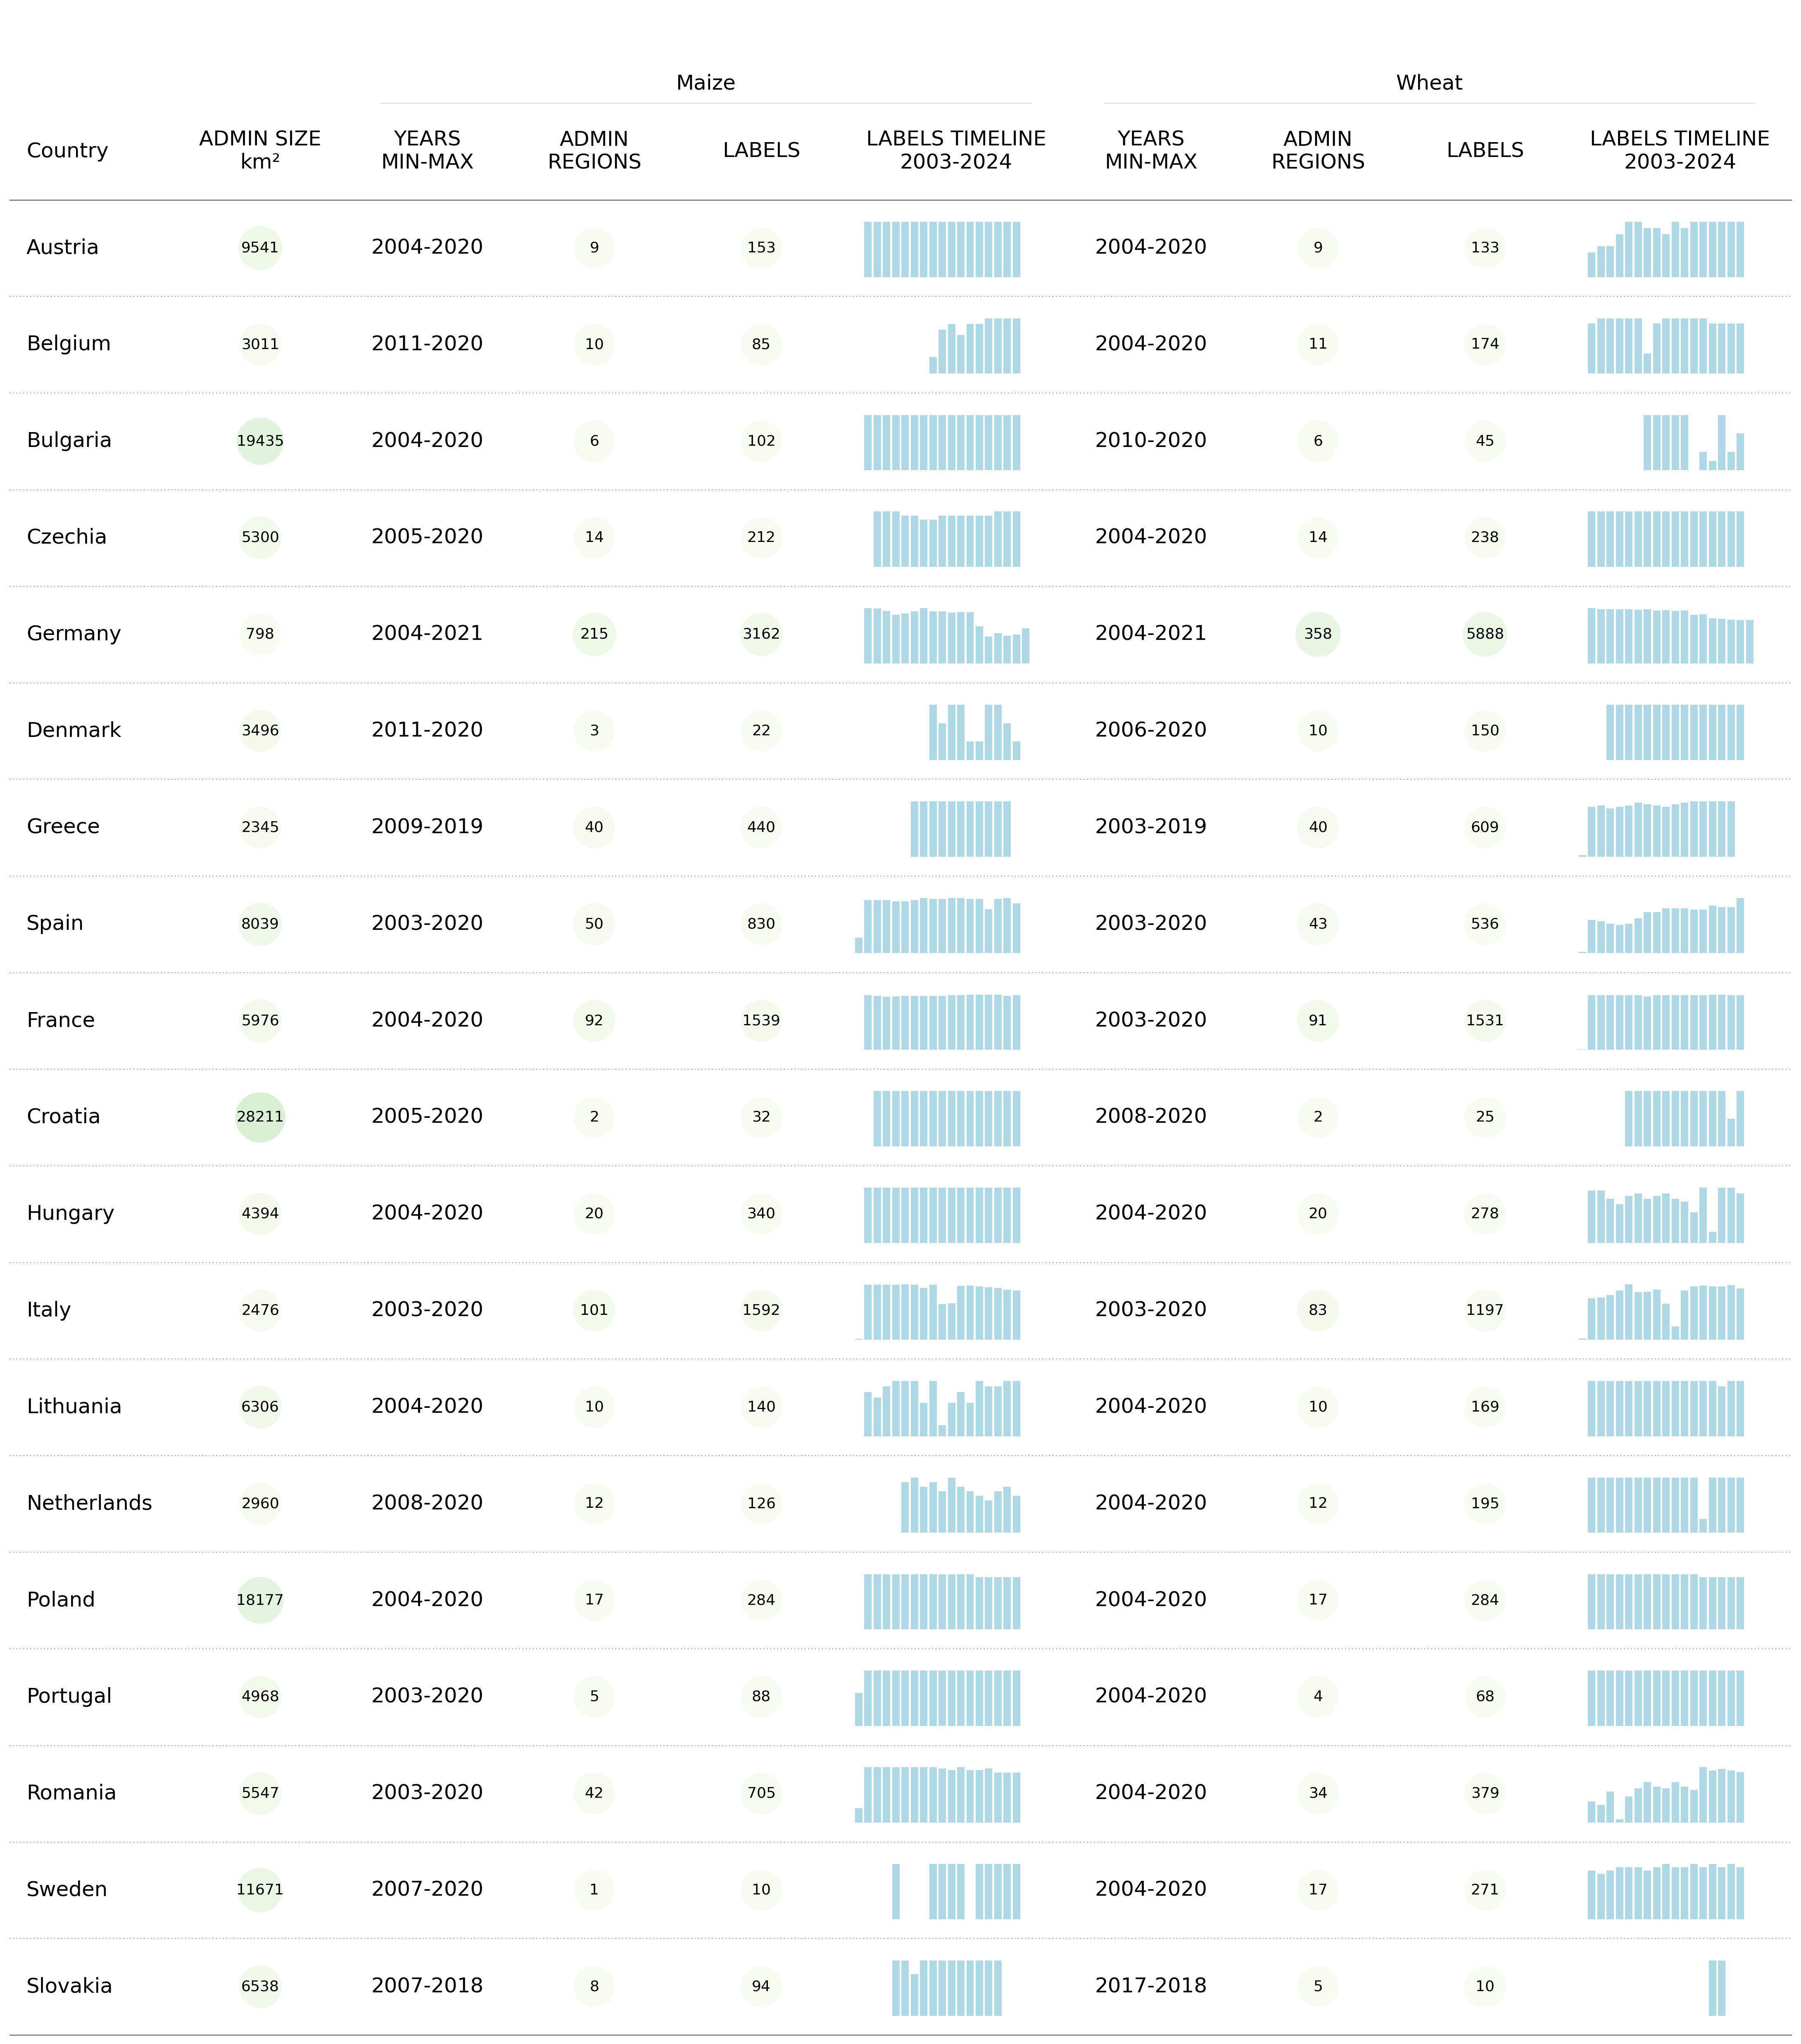

In [67]:
from plottable import ColDef, Table

fig, ax = plt.subplots(figsize=(56, 64))

eu_summary_df = summary_df[summary_df["country_code"].isin(EU_COUNTRIES)]

maize_label = "Maize"
wheat_label = "Wheat"

tab = Table(
            eu_summary_df,
            columns=["area_sqkm", "maize_years", "maize_adm_id_count", "maize_labels_count", "maize_labels_count_per_year",
                     "wheat_years", "wheat_adm_id_count", "wheat_labels_count", "wheat_labels_count_per_year"],
            column_definitions=[
                ColDef(name="Country", title ="Country",
                        textprops={"ha": "left"},
                        width=0.75,
                       ),

                # ColDef("flag",title="", width=1,
                #        textprops={"ha": "center"},
                #        plot_fn=circled_image,),
                ColDef(name="area_sqkm",
                       title="ADMIN SIZE\nkm²",
                       formatter=handle_na,
                       width=0.75,
                       plot_fn=lambda ax, val: custom_plot_fn(ax, val, cmap=color_map_area, min=min_area, max=max_area),
                       ),

                ColDef(name="maize_adm_id_count",
                       title="ADMIN\nREGIONS",
                       formatter=handle_na,
                       width=0.75,
                       plot_fn=lambda ax, val: custom_plot_fn(ax, val, cmap=color_map_adm, min=min_adm, max=max_adm),
                       group=maize_label),

                ColDef(name="maize_labels_count",
                       title="LABELS",
                       formatter=handle_na,
                       width=0.75,
                       plot_fn=lambda ax, val: custom_plot_fn(ax, val, cmap=color_map_labels, min=min_labels, max=max_labels),
                       group=maize_label),

                ColDef(name="maize_years",
                       title="YEARS\nMIN-MAX",
                       textprops={
                         "ha": "center",
                       },
                       width=0.75,
                       group=maize_label),

                ColDef(name="maize_labels_count_per_year",
                       title="LABELS TIMELINE\n2003-2024", width=1.0,
                       group= maize_label,
                       plot_fn=densities_plot,
                       textprops={"ha": "center"}),

                ColDef(name="wheat_adm_id_count",
                       title="ADMIN\nREGIONS",
                       formatter=handle_na,
                       width=0.75,
                       plot_fn=lambda ax, val: custom_plot_fn(ax, val, cmap=color_map_adm, min=min_adm, max=max_adm),
                       group=wheat_label),

                ColDef(name="wheat_labels_count",
                       title="LABELS",
                       formatter=handle_na,
                       width=0.75,
                       plot_fn=lambda ax, val: custom_plot_fn(ax, val, cmap=color_map_labels, min=min_labels, max=max_labels),
                       group=wheat_label),

                ColDef(name="wheat_years",
                       title="YEARS\nMIN-MAX",
                       textprops={
                         "ha": "center",
                       },
                       width=0.75,
                       group=wheat_label),

                ColDef(name="wheat_labels_count_per_year",
                       title="LABELS TIMELINE\n2003-2024", width=1.0,
                       group= wheat_label,
                       plot_fn=densities_plot,
                       textprops={"ha": "center"}),
                ],
            row_dividers=True,
            col_label_divider=True,
            footer_divider=True,
            textprops={
                "fontsize": 36,
                "font": "sans serif",
                "ha":"center",
            },
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
        )

plt.show()

### Plot other countries

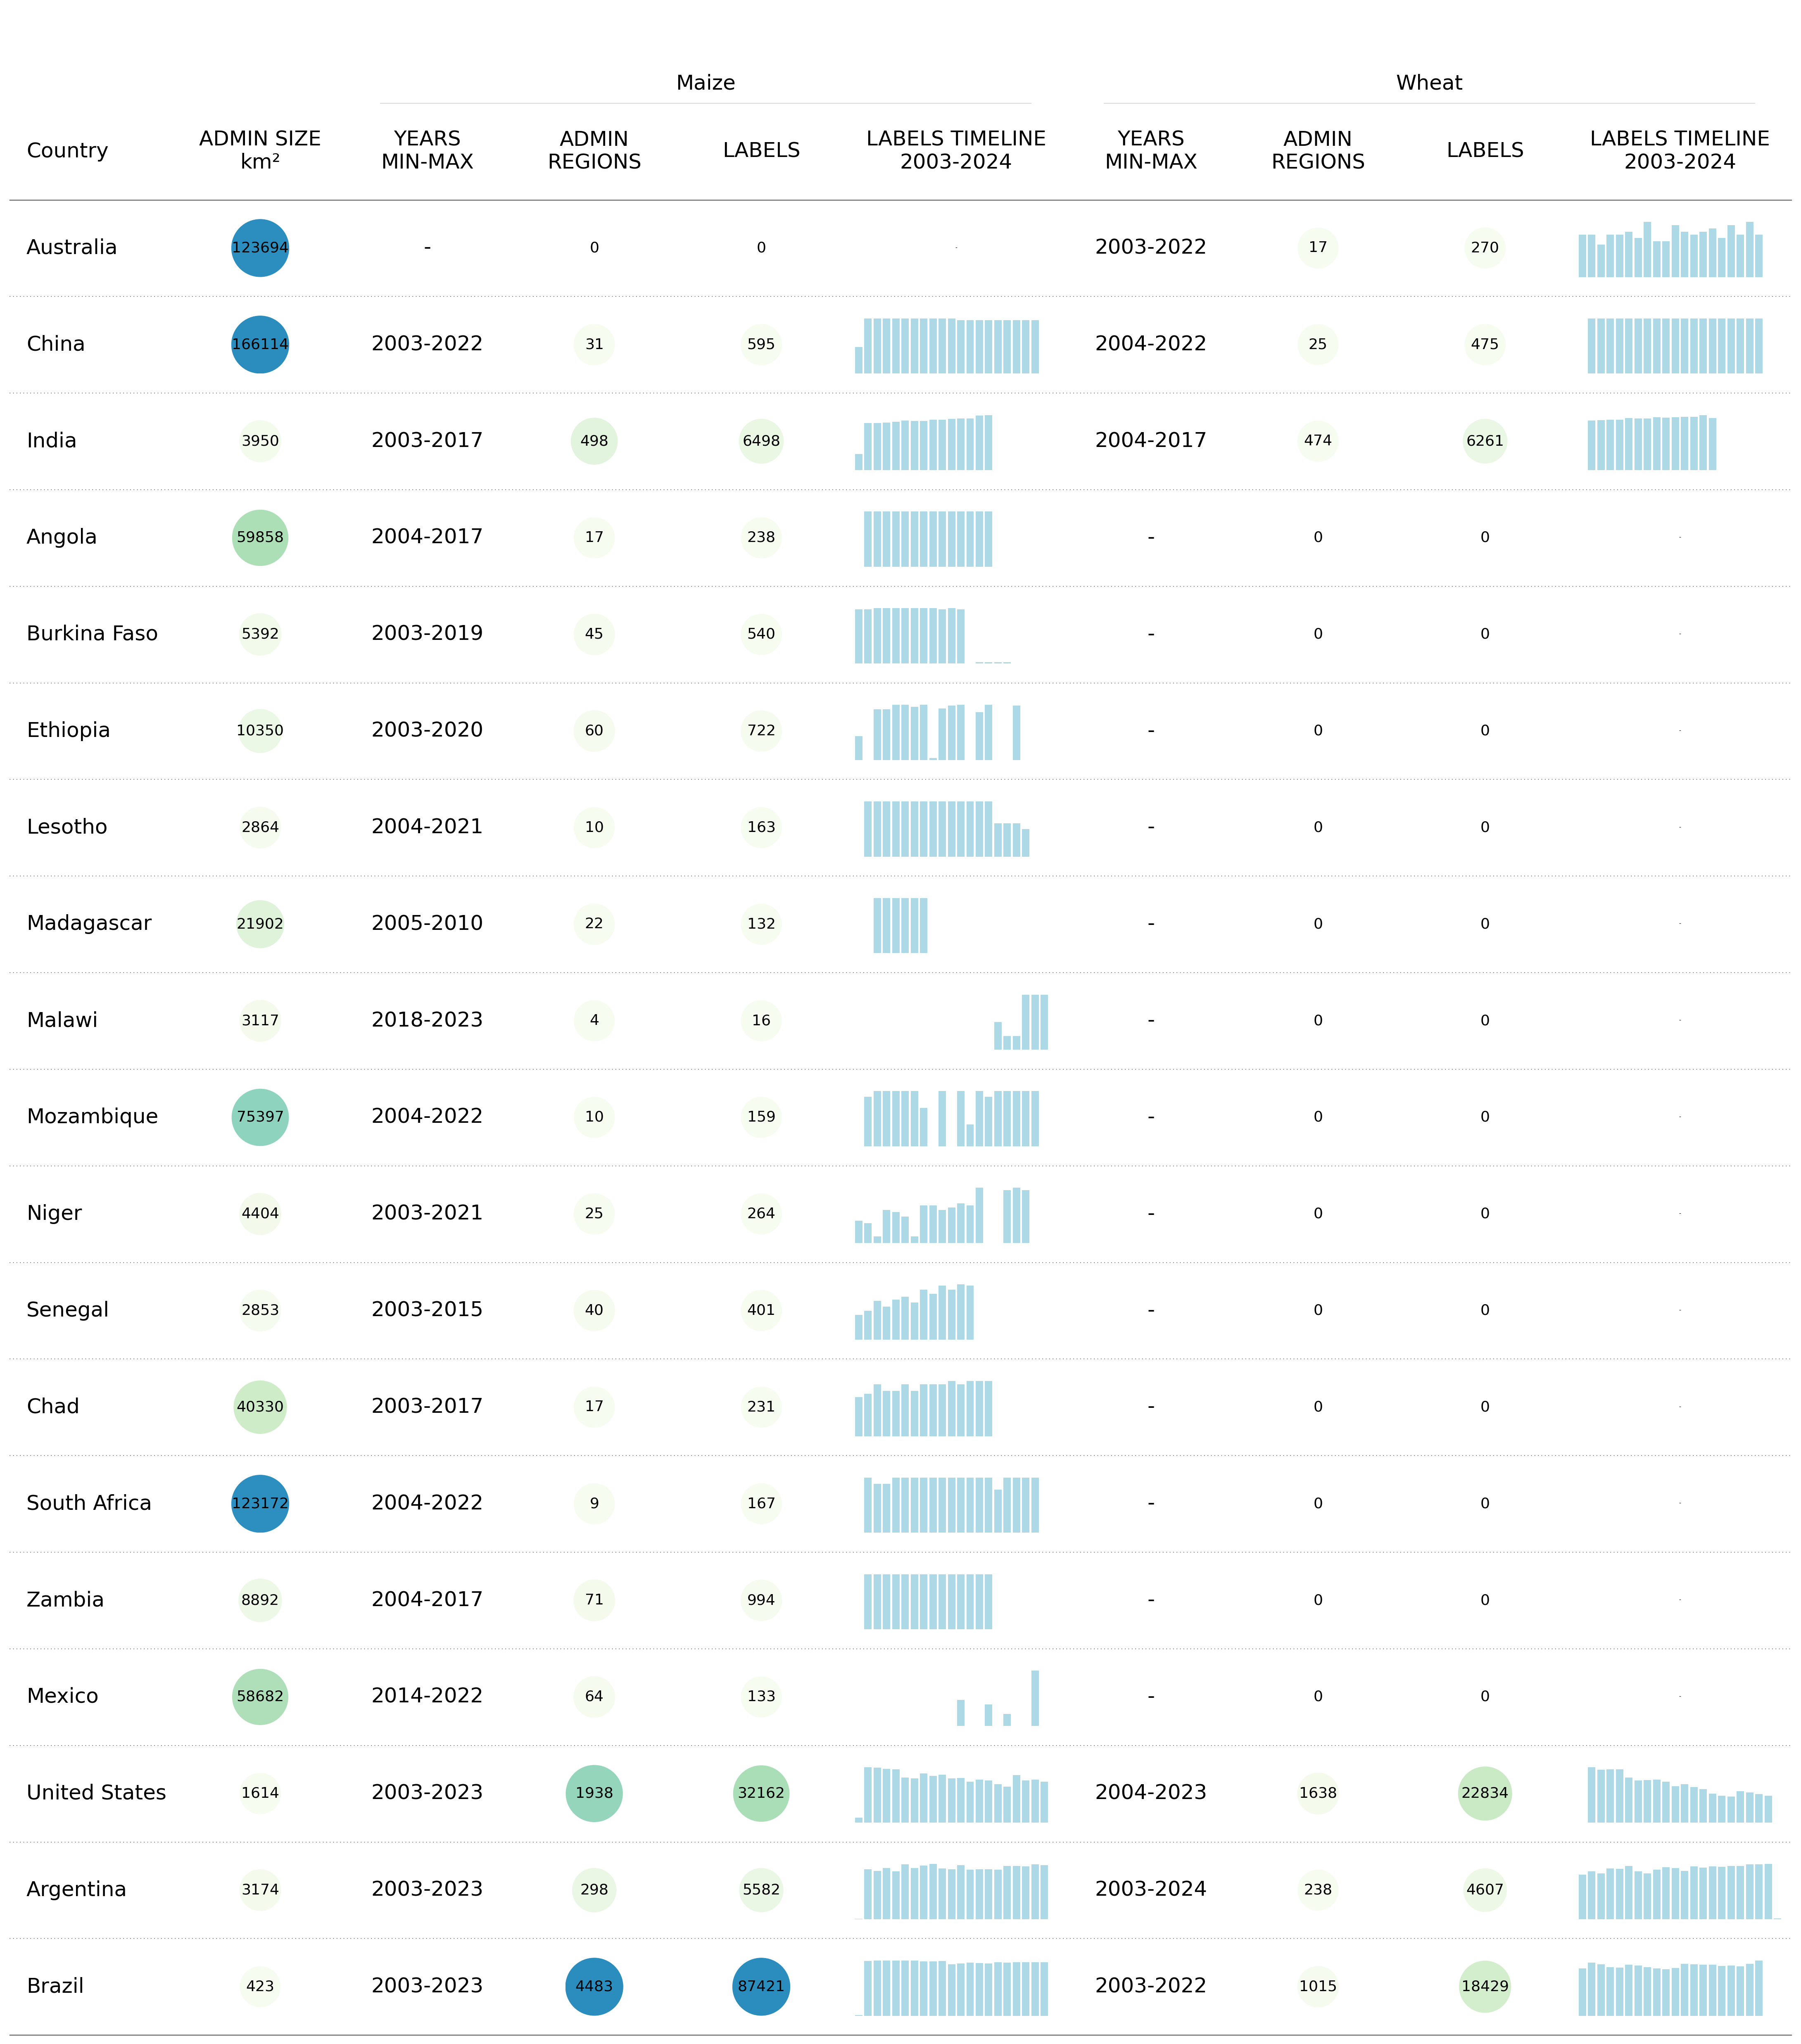

In [68]:
from plottable import ColDef, Table

fig, ax = plt.subplots(figsize=(56, 64))

noneu_summary_df = summary_df[~summary_df["country_code"].isin(EU_COUNTRIES)]


tab = Table(
            noneu_summary_df,
            columns=["area_sqkm", "maize_years", "maize_adm_id_count", "maize_labels_count", "maize_labels_count_per_year",
                     "wheat_years", "wheat_adm_id_count", "wheat_labels_count", "wheat_labels_count_per_year"],
            column_definitions=[
                ColDef(name="Country", title ="Country",
                        textprops={"ha": "left"},
                        width=0.75,
                       ),

                # ColDef("flag",title="", width=1,
                #        textprops={"ha": "center"},
                #        plot_fn=circled_image,),

                ColDef(name="area_sqkm",
                       title="ADMIN SIZE\nkm²",
                       formatter=handle_na,
                       width=0.75,
                       plot_fn=lambda ax, val: custom_plot_fn(ax, val, cmap=color_map_area, min=min_area, max=max_area),
                       ),

                ColDef(name="maize_adm_id_count",
                       title="ADMIN\nREGIONS",
                       formatter=handle_na,
                       width=0.75,
                       plot_fn=lambda ax, val: custom_plot_fn(ax, val, cmap=color_map_adm, min=min_adm, max=max_adm),
                       group=maize_label),

                ColDef(name="maize_labels_count",
                       title="LABELS",
                       formatter=handle_na,
                       width=0.75,
                       plot_fn=lambda ax, val: custom_plot_fn(ax, val, cmap=color_map_labels, min=min_labels, max=max_labels),
                       group=maize_label),

                ColDef(name="maize_years",
                       title="YEARS\nMIN-MAX",
                       textprops={
                         "ha": "center",
                       },
                       width=0.75,
                       group=maize_label),

                ColDef(name="maize_labels_count_per_year",
                       title="LABELS TIMELINE\n2003-2024", width=1.0,
                       group= maize_label,
                       plot_fn=densities_plot,
                       textprops={"ha": "center"}),

                ColDef(name="wheat_adm_id_count",
                       title="ADMIN\nREGIONS",
                       formatter=handle_na,
                       width=0.75,
                       plot_fn=lambda ax, val: custom_plot_fn(ax, val, cmap=color_map_labels, min=min_labels, max=max_labels),
                       group=wheat_label),

                ColDef(name="wheat_labels_count",
                       title="LABELS",
                       formatter=handle_na,
                       width=0.75,
                       plot_fn=lambda ax, val: custom_plot_fn(ax, val, cmap=color_map_labels, min=min_labels, max=max_labels),
                       group=wheat_label),

                ColDef(name="wheat_years",
                       title="YEARS\nMIN-MAX",
                       textprops={
                         "ha": "center",
                       },
                       width=0.75,
                       group=wheat_label),

                ColDef(name="wheat_labels_count_per_year",
                       title="LABELS TIMELINE\n2003-2024", width=1.0,
                       group= wheat_label,
                       plot_fn=densities_plot,
                       textprops={"ha": "center"}),
                ],
            row_dividers=True,
            col_label_divider=True,
            footer_divider=True,
            textprops={
                "fontsize": 36,
                "font": "sans serif",
                "ha":"center",
            },
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
        )

plt.show()